In [1]:
# import pandas

# import modin.pandas as pd
# from modin.config import Engine
# Engine.put("dask") 

In [2]:
import os
import daal4py as d4p
from xgboost import XGBClassifier
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pio.renderers.default='notebook_connected' 
intel_pal, color=['#0071C5','#FCBB13'], ['#7AB5E1','#FCE7B2']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

In [3]:
# from distributed import Client
# client = Client()

# data = pd.read_csv("dataset.csv")

data = pd.read_csv("50k_dataset.csv")
data = data.drop('Index', axis=1)
print("Total rows in the DataFrame:", len(data))

print(data.dtypes)
display(data.isna().sum())

Total rows in the DataFrame: 50000
pH                        float64
Iron                      float64
Nitrate                   float64
Chloride                  float64
Lead                      float64
Zinc                      float64
Color                      object
Turbidity                 float64
Fluoride                  float64
Copper                    float64
Odor                      float64
Sulfate                   float64
Conductivity              float64
Chlorine                  float64
Manganese                 float64
Total Dissolved Solids    float64
Source                     object
Water Temperature         float64
Air Temperature           float64
Month                      object
Day                       float64
Time of Day               float64
Target                      int64
dtype: object


pH                         936
Iron                       337
Nitrate                    946
Chloride                  1426
Lead                       228
Zinc                      1304
Color                       44
Turbidity                  417
Fluoride                  1571
Copper                    1652
Odor                      1494
Sulfate                   1622
Conductivity              1347
Chlorine                   467
Manganese                  928
Total Dissolved Solids      13
Source                     690
Water Temperature         1371
Air Temperature            226
Month                      784
Day                        785
Time of Day                978
Target                       0
dtype: int64

In [4]:
# handle missing values
start_fill = time.time()
for column in data.columns:
    if data[column].dtype == 'object':
        mode = data[column].mode().iloc[0]
        data[column].fillna(mode, inplace=True)
    else:
        median = data[column].median()
        data[column].fillna(median, inplace=True)

end_fill = time.time()
print("fill missing value took: {:.2f} s".format(end_fill - start_fill))

# drop duplicated rows
data = data.drop_duplicates()

# transform `Color` to number
color_labels, color_unique_values = pd.factorize(data['Color'])
data['Color'] = color_labels
# transform `Source` to number
source_labels, source_unique_values = pd.factorize(data['Source'])
data['Source'] = source_labels

fill missing value took: 0.04 s


In [5]:
display(data.isna().sum())
missing = data.isna().sum().sum()
duplicates = data.duplicated().sum()
print("\nThere are {:,.0f} missing values in the data.".format(missing))
print("There are {:,.0f} duplicate records in the data.".format(duplicates))

display(data.head())

pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Color                     0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor                      0
Sulfate                   0
Conductivity              0
Chlorine                  0
Manganese                 0
Total Dissolved Solids    0
Source                    0
Water Temperature         0
Air Temperature           0
Month                     0
Day                       0
Time of Day               0
Target                    0
dtype: int64


There are 0 missing values in the data.
There are 0 duplicate records in the data.


pH      Iron    Nitrate    Chloride           Lead      Zinc  Color  \
0  8.363202  0.026002  13.279366  224.654964   3.294790e-98  3.659572      0   
1  7.180996  0.013533  11.871386  412.075502  8.584804e-122  0.528878      1   
2  7.192017  0.000233   7.879818  163.046126  3.315243e-285  4.442571      2   
3  7.111144  0.000199   6.396389  209.512297   1.157846e-41  2.336371      1   
4  7.392138  0.000005   6.080465  127.739585  7.611868e-104  1.637140      1   

   Turbidity  Fluoride    Copper  ...  Chlorine     Manganese  \
0   2.928357  0.208108  3.102599  ...  2.809410  3.007019e-04   
1   0.430281  0.663251  0.034603  ...  4.244976  2.892038e-01   
2   0.000043  1.085084  0.719717  ...  2.754725  7.013207e-04   
3   0.004361  0.794863  0.950165  ...  3.494851  3.488892e-07   
4   0.529798  0.213287  0.398200  ...  2.811408  1.707332e-03   

   Total Dissolved Solids  Source  Water Temperature  Air Temperature  \
0               93.615788       0          15.288683        59.380597   
1              166.189438       1          24.280234        35.031716   
2              462.827569       2           8.561498        50.030080   
3              397.995515       2          21.524377        68.570551   
4              220.944741       1          10.799109        60.586970   

      Month   Day  Time of Day Target  
0       May   2.0          5.0      1  
1      July  10.0         13.0      1  
2   January   2.0          7.0      1  
3  December  27.0         19.0      0  
4   January  17.0         16.0      0  

[5 rows x 23 columns]

In [6]:
def display_stats():
    
    """
    Function to display descriptive statistics of numerical variables,
    includes skewness & kurtosis.   
    """
    
    df = data.describe()
    skewness = pd.DataFrame(data.skew(numeric_only=True), columns=['skewness']).T
    kurtosis = pd.DataFrame(data.kurt(numeric_only=True), columns=['kurtosis']).T
    df = pd.concat([df, skewness, kurtosis], axis=0)
    display(df.style.format('{:,.3f}').background_gradient(subset=(df.index[1:],df.columns[:]), cmap='GnBu'))

display_stats()

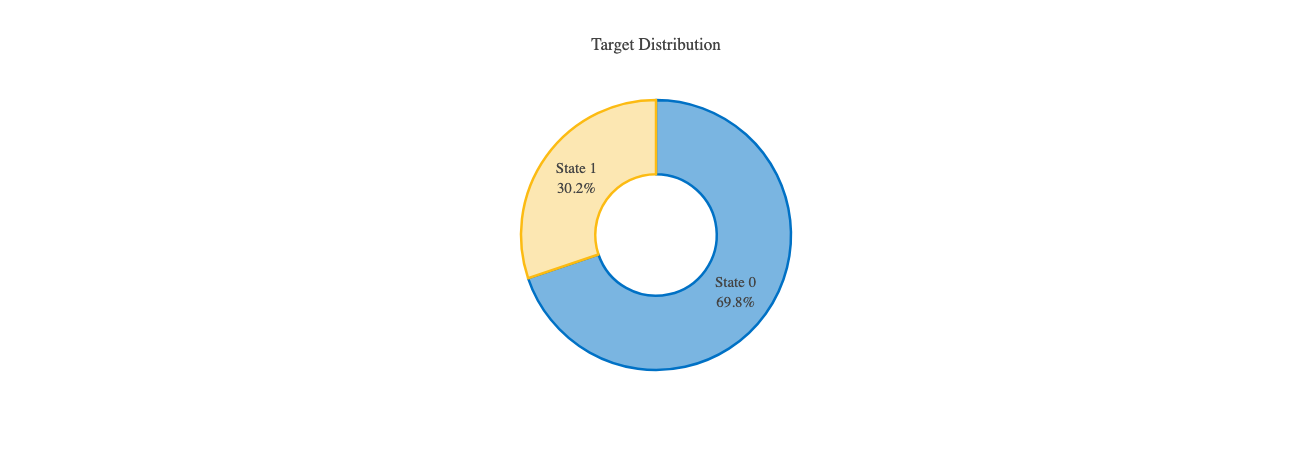

State 0    0.698058
State 1    0.301942
Name: Target, dtype: float64


In [21]:
# show target distribution
target=data['Target'].value_counts(normalize=True)
target.rename(index={1:'State 1',0:'State 0'},inplace=True)
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45, 
                     text=target.index, sort=False, showlegend=False,
                     marker=dict(colors=color,line=dict(color=intel_pal,width=2.5)),
                     hovertemplate = "%{label}: <b>%{value:.2f}%</b><extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution',width=700,height=450,
                  uniformtext_minsize=15, uniformtext_mode='hide')
fig.show() 

In [ ]:
cat_cols,float_cols=[],['Target']
for col in data.columns:
    if data[col].value_counts().count() < 10:
        cat_cols.append(col)
    else:
        float_cols.append(col)

/home/u188545/tmp/ipykernel_3674042/2601483805.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.drop(columns_to_drop, axis=1, inplace=True)


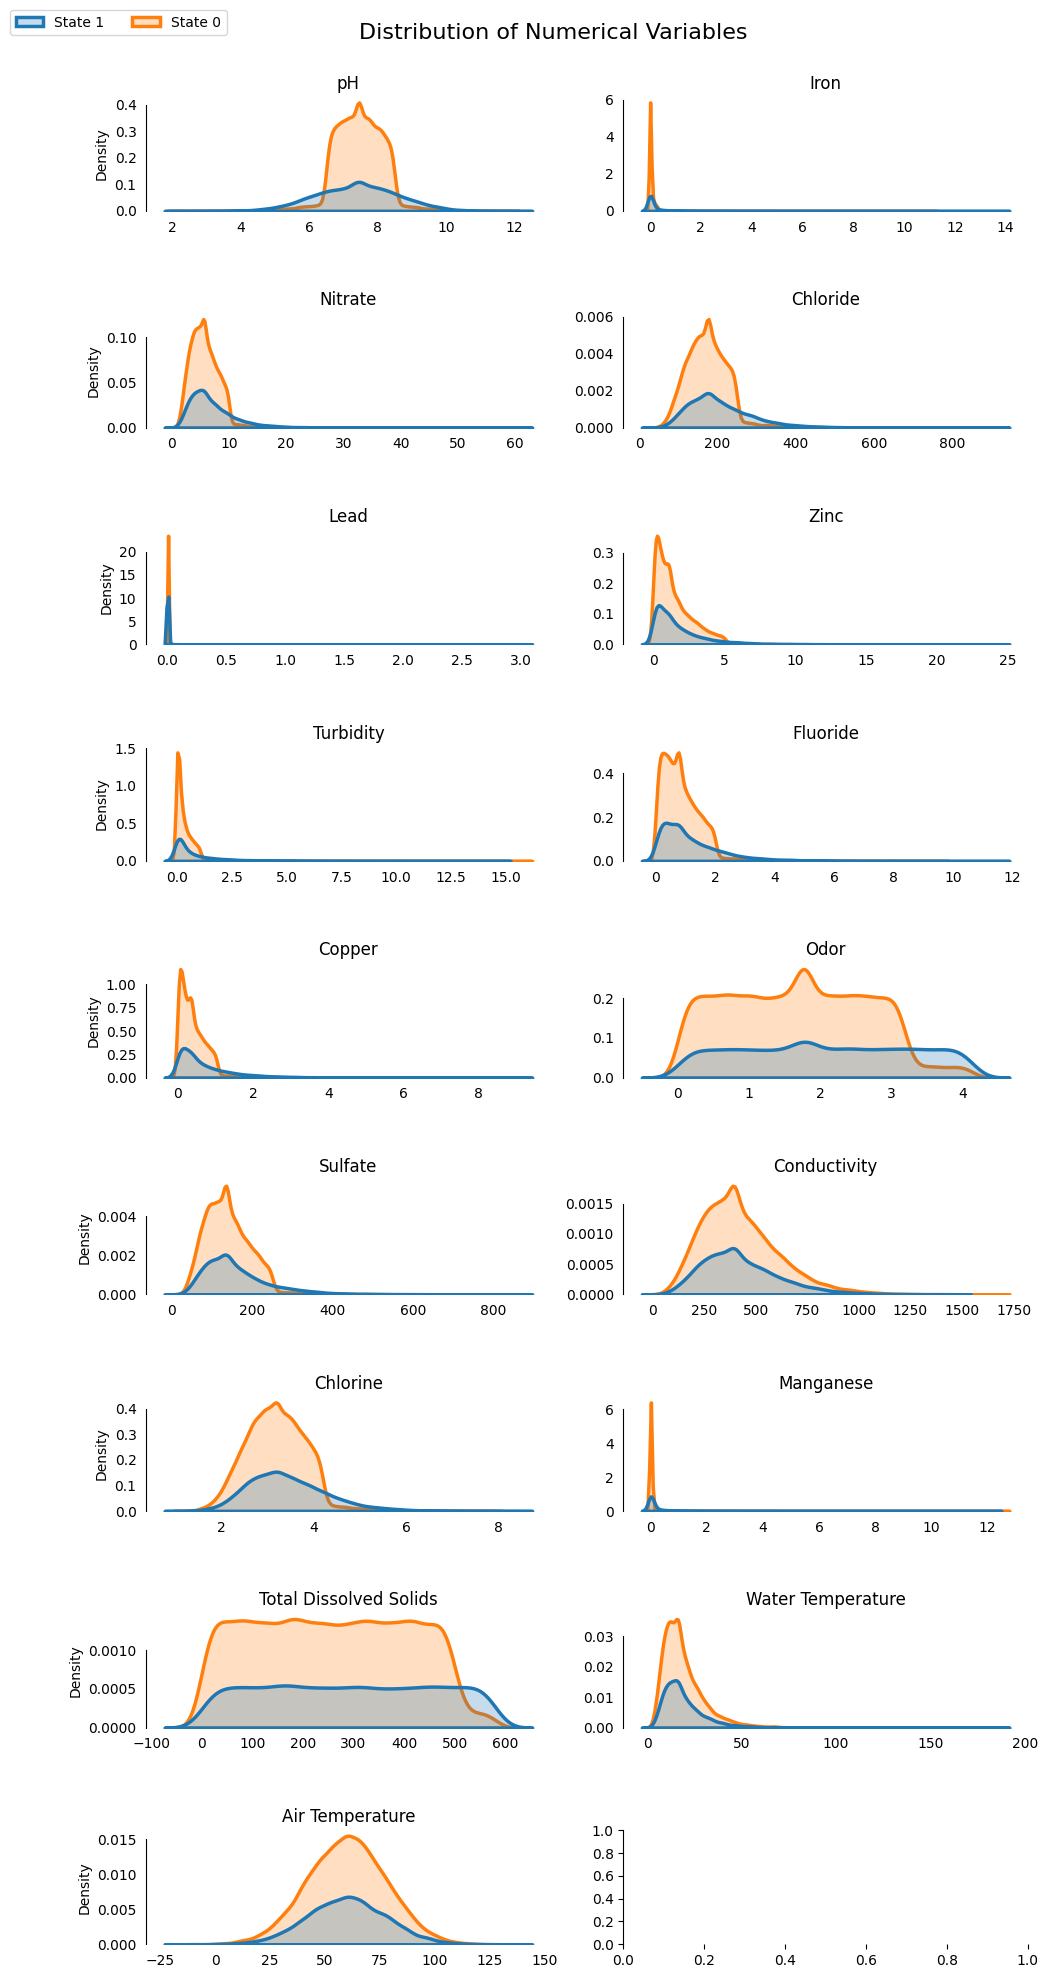

In [8]:
plot_df=data[float_cols]

# do not display distribution with column `Month` and `Day`
columns_to_drop = ['Month', 'Day']
plot_df.drop(columns_to_drop, axis=1, inplace=True)

fig, ax = plt.subplots(9,2, figsize=(10,20))
fig.suptitle('Distribution of Numerical Variables',fontsize=16)
row=0
col=[0,1]*9

for i, column in enumerate(plot_df.columns[1:-1]):
    if (i!=0)&(i%2==0):
        row+=1
    
    sns.kdeplot(
        x=column, hue='Target', hue_order=[1, 0],
        label=['State 1', 'State 0'], data=plot_df,
        fill=True, linewidth=2.5, legend=False, ax=ax[row, col[i]]
    )
    
    ax[row,col[i]].tick_params(left=False, bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%2==0 else ''))

handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['State 1','State 0'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.99))
sns.despine(bottom=True, trim=True)
plt.tight_layout()

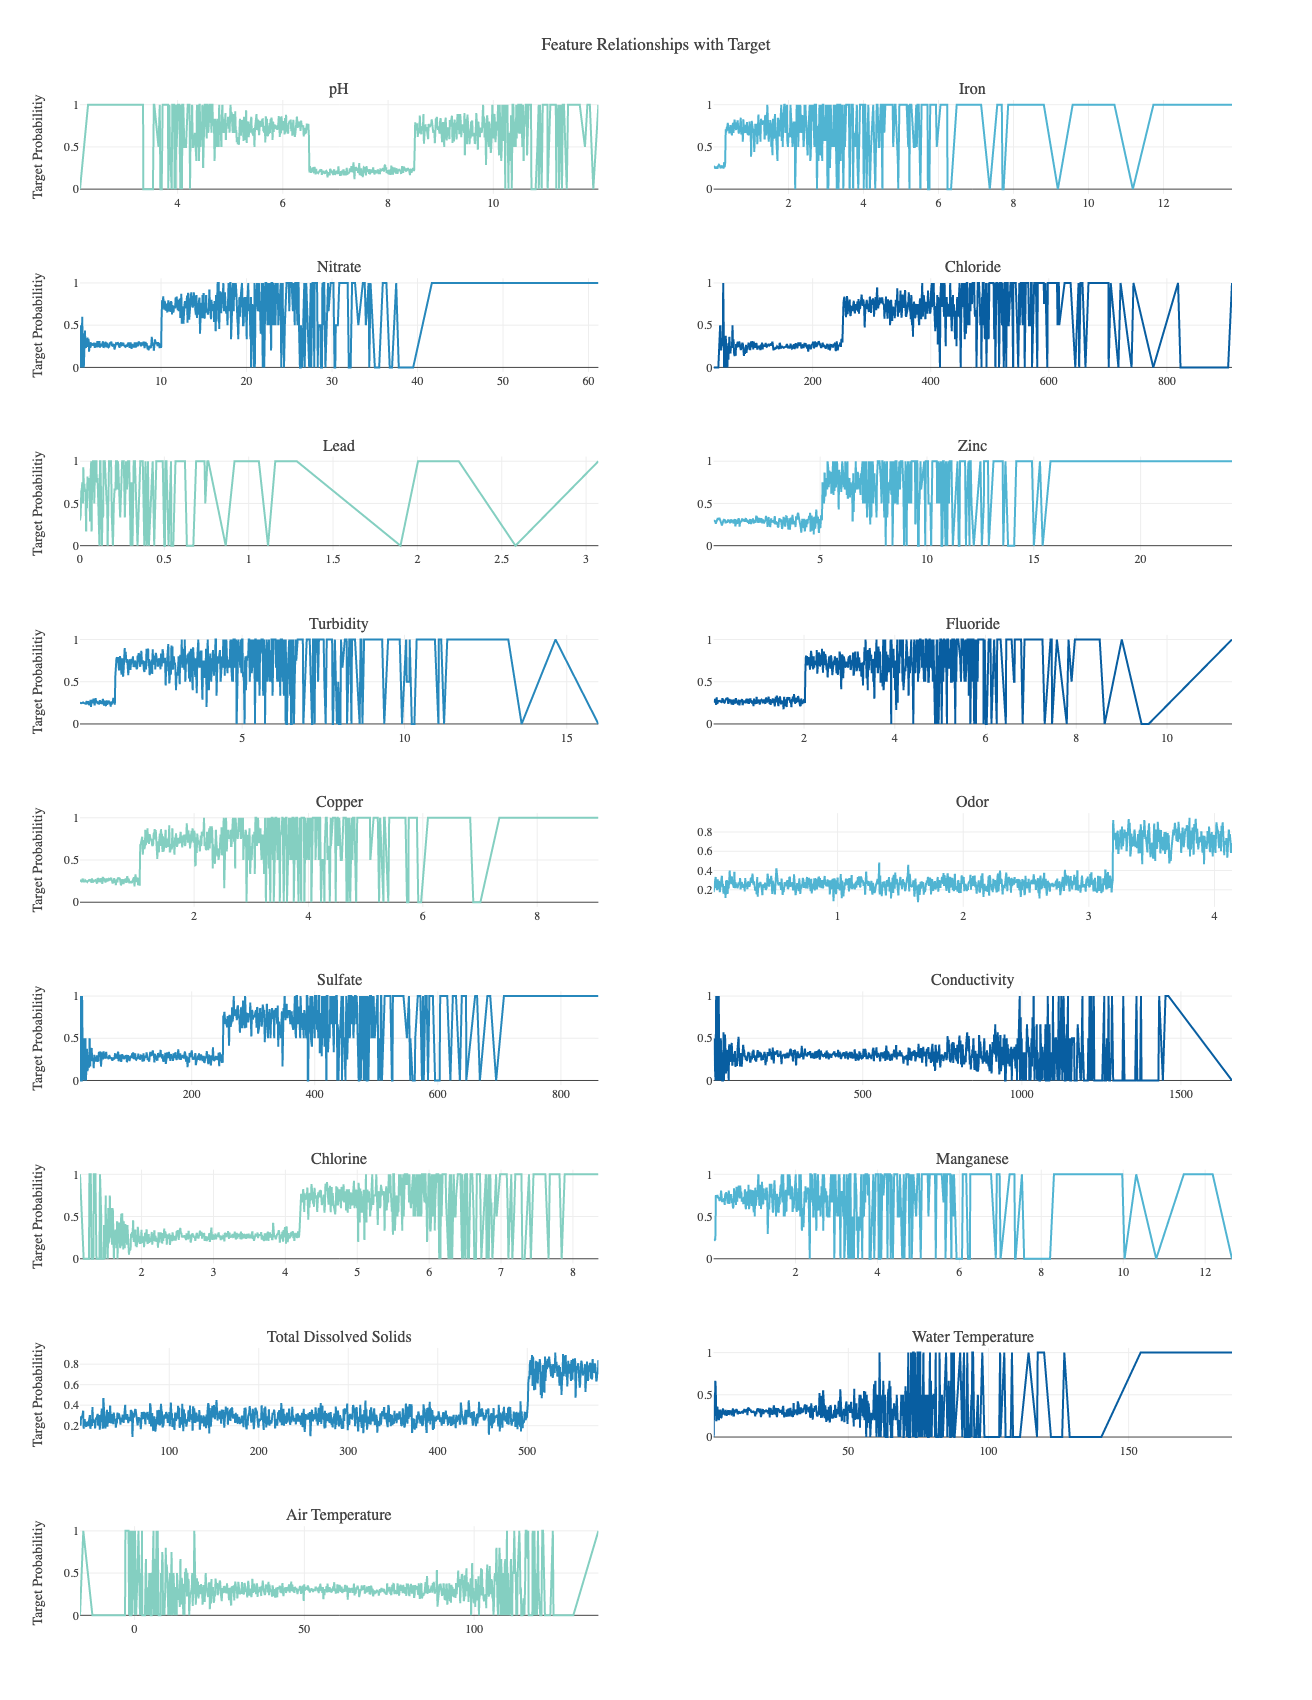

In [9]:
fig=make_subplots(rows=9,cols=2, subplot_titles=float_cols[1:-3])
col=[1,2]*9
row=0
pal=sns.color_palette("GnBu",20).as_hex()[9:][::3]

for i, column in enumerate(data[float_cols].columns[1:-3]):
    if i%2 == 0:
        row += 1
    df = pd.concat([data[column], data['Target']], axis=1)

    df['bins'] = pd.cut(df[column], 1000)
    df['mean'] = df.bins.apply(lambda x: x.mid)

    df = df.groupby('mean')[[column,'Target']].transform('mean')
    df = df.drop_duplicates(subset=[column]).sort_values(by=column)
    
    fig.add_trace(go.Scatter(x=df[column], y=df.Target, name=column,
                             marker_color=pal[i % len(pal)], showlegend=False),
                  row=row, col=col[i])
    fig.update_xaxes(zeroline=False, row=row, col=col[i])
    if i%2 == 0:
        fig.update_yaxes(title='Target Probabilitiy',row=row,col=col[i]) 
fig.update_layout(template=temp, title='Feature Relationships with Target', hovermode="x unified",height=1700,width=1200)
fig.show()

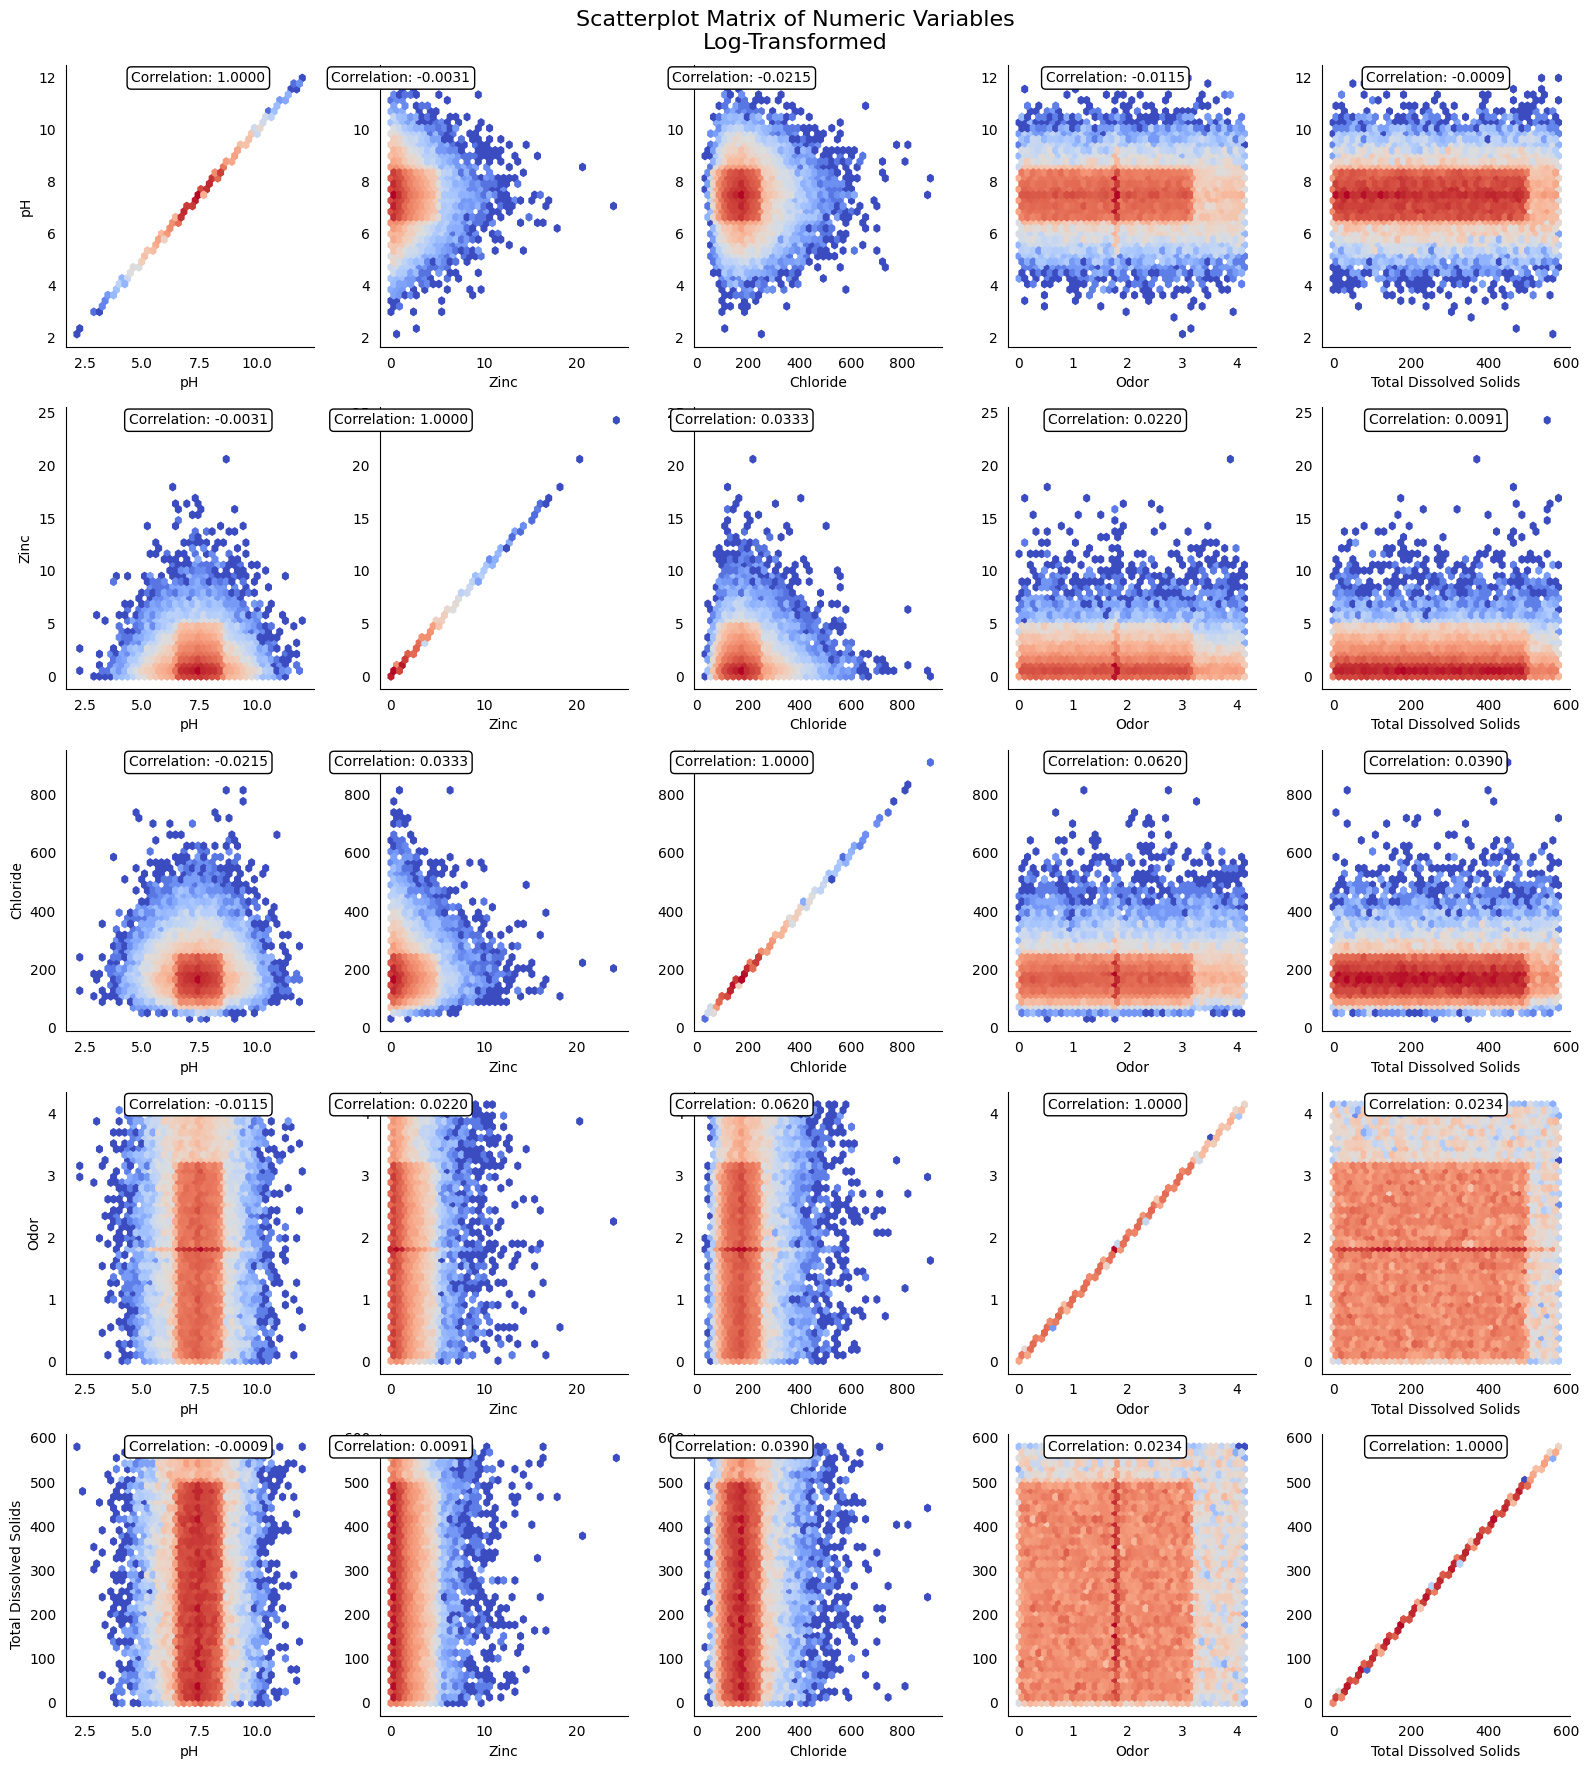

In [10]:
check_cols = ['pH', 'Zinc', 'Chloride', 'Odor', 'Total Dissolved Solids']
check_cols_len = len(check_cols)

plot_df=data[check_cols]
fig, ax = plt.subplots(check_cols_len, check_cols_len, figsize=(16,18))
fig.suptitle('Scatterplot Matrix of Numeric Variables\nLog-Transformed',fontsize=16)
for i, col in enumerate(check_cols):
    for j, iter_col in enumerate(check_cols):
        ax[i,j].hexbin(x=iter_col, y=col, data=plot_df, bins='log', gridsize=40, cmap='coolwarm')
        ax[i,j].set(xlabel=iter_col, ylabel=(col if j % check_cols_len == 0 else ''))
        ax[i,j].text(plot_df[iter_col].median(), plot_df[col].max(), 
                     'Correlation: {:.4f}'.format(plot_df[[col,iter_col]].corr().iloc[1,0]), 
                   ha="center", va="center",bbox=dict(boxstyle="round,pad=0.3",fc="white"))
        ax[i,j].tick_params(left=False,bottom=False)    

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

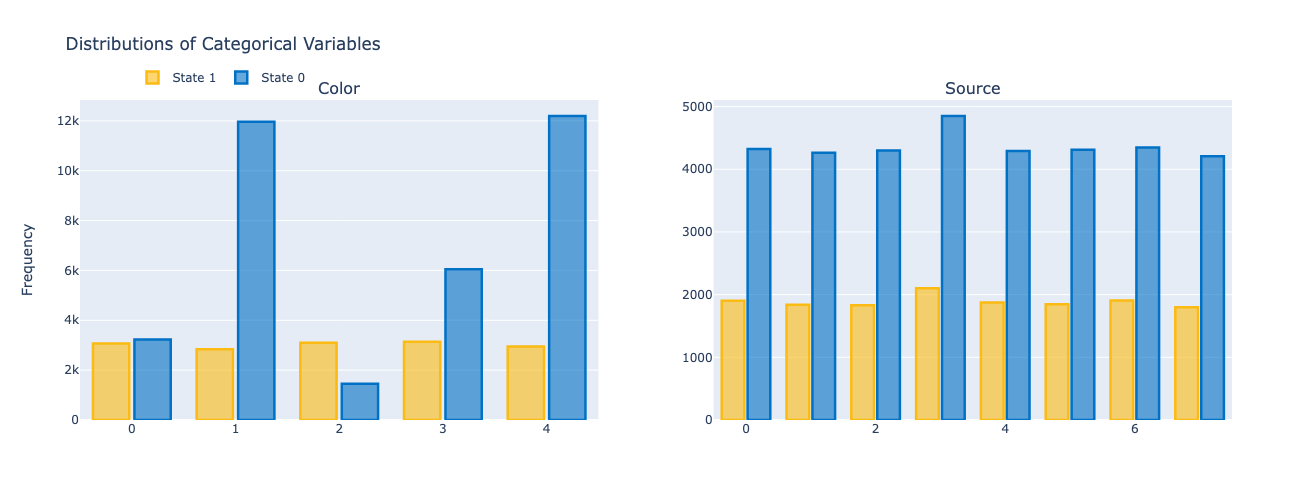

In [19]:
fig = make_subplots(rows=1, cols=2, subplot_titles=[c for c in cat_cols if c!='Target'])
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.6)) for i in intel_pal]
row=0
c=[1,2]*1
for i, col in enumerate(c for c in cat_cols if c!='Target'):
    if i%3==0:
        row+=1
    df=data.groupby(col)['Target'].value_counts().rename('count').reset_index()
    fig.add_trace(go.Bar(x=df[df.Target==1][col], y=df[df.Target==1]['count'],width=.35,
                         marker_color=rgb[1], marker_line=dict(color=intel_pal[1],width=2.5), 
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 1', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=df[df.Target==0][col], y=df[df.Target==0]['count'],width=.35,
                         marker_color=rgb[0], marker_line=dict(color=intel_pal[0],width=2.5),
                         hovertemplate='Value: %{x}<br>Count: %{y}',
                         name='State 0', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    if i%3==0:
        fig.update_yaxes(title='Frequency',row=row,col=c[i])
fig.update_layout(title="Distributions of Categorical Variables",
                  legend=dict(orientation="h",yanchor="bottom",y=1.025,xanchor="right",x=.2),
                  barmode='group',height=500,width=900)
fig.show()

/home/u188545/tmp/ipykernel_3674042/1110730520.py:34: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



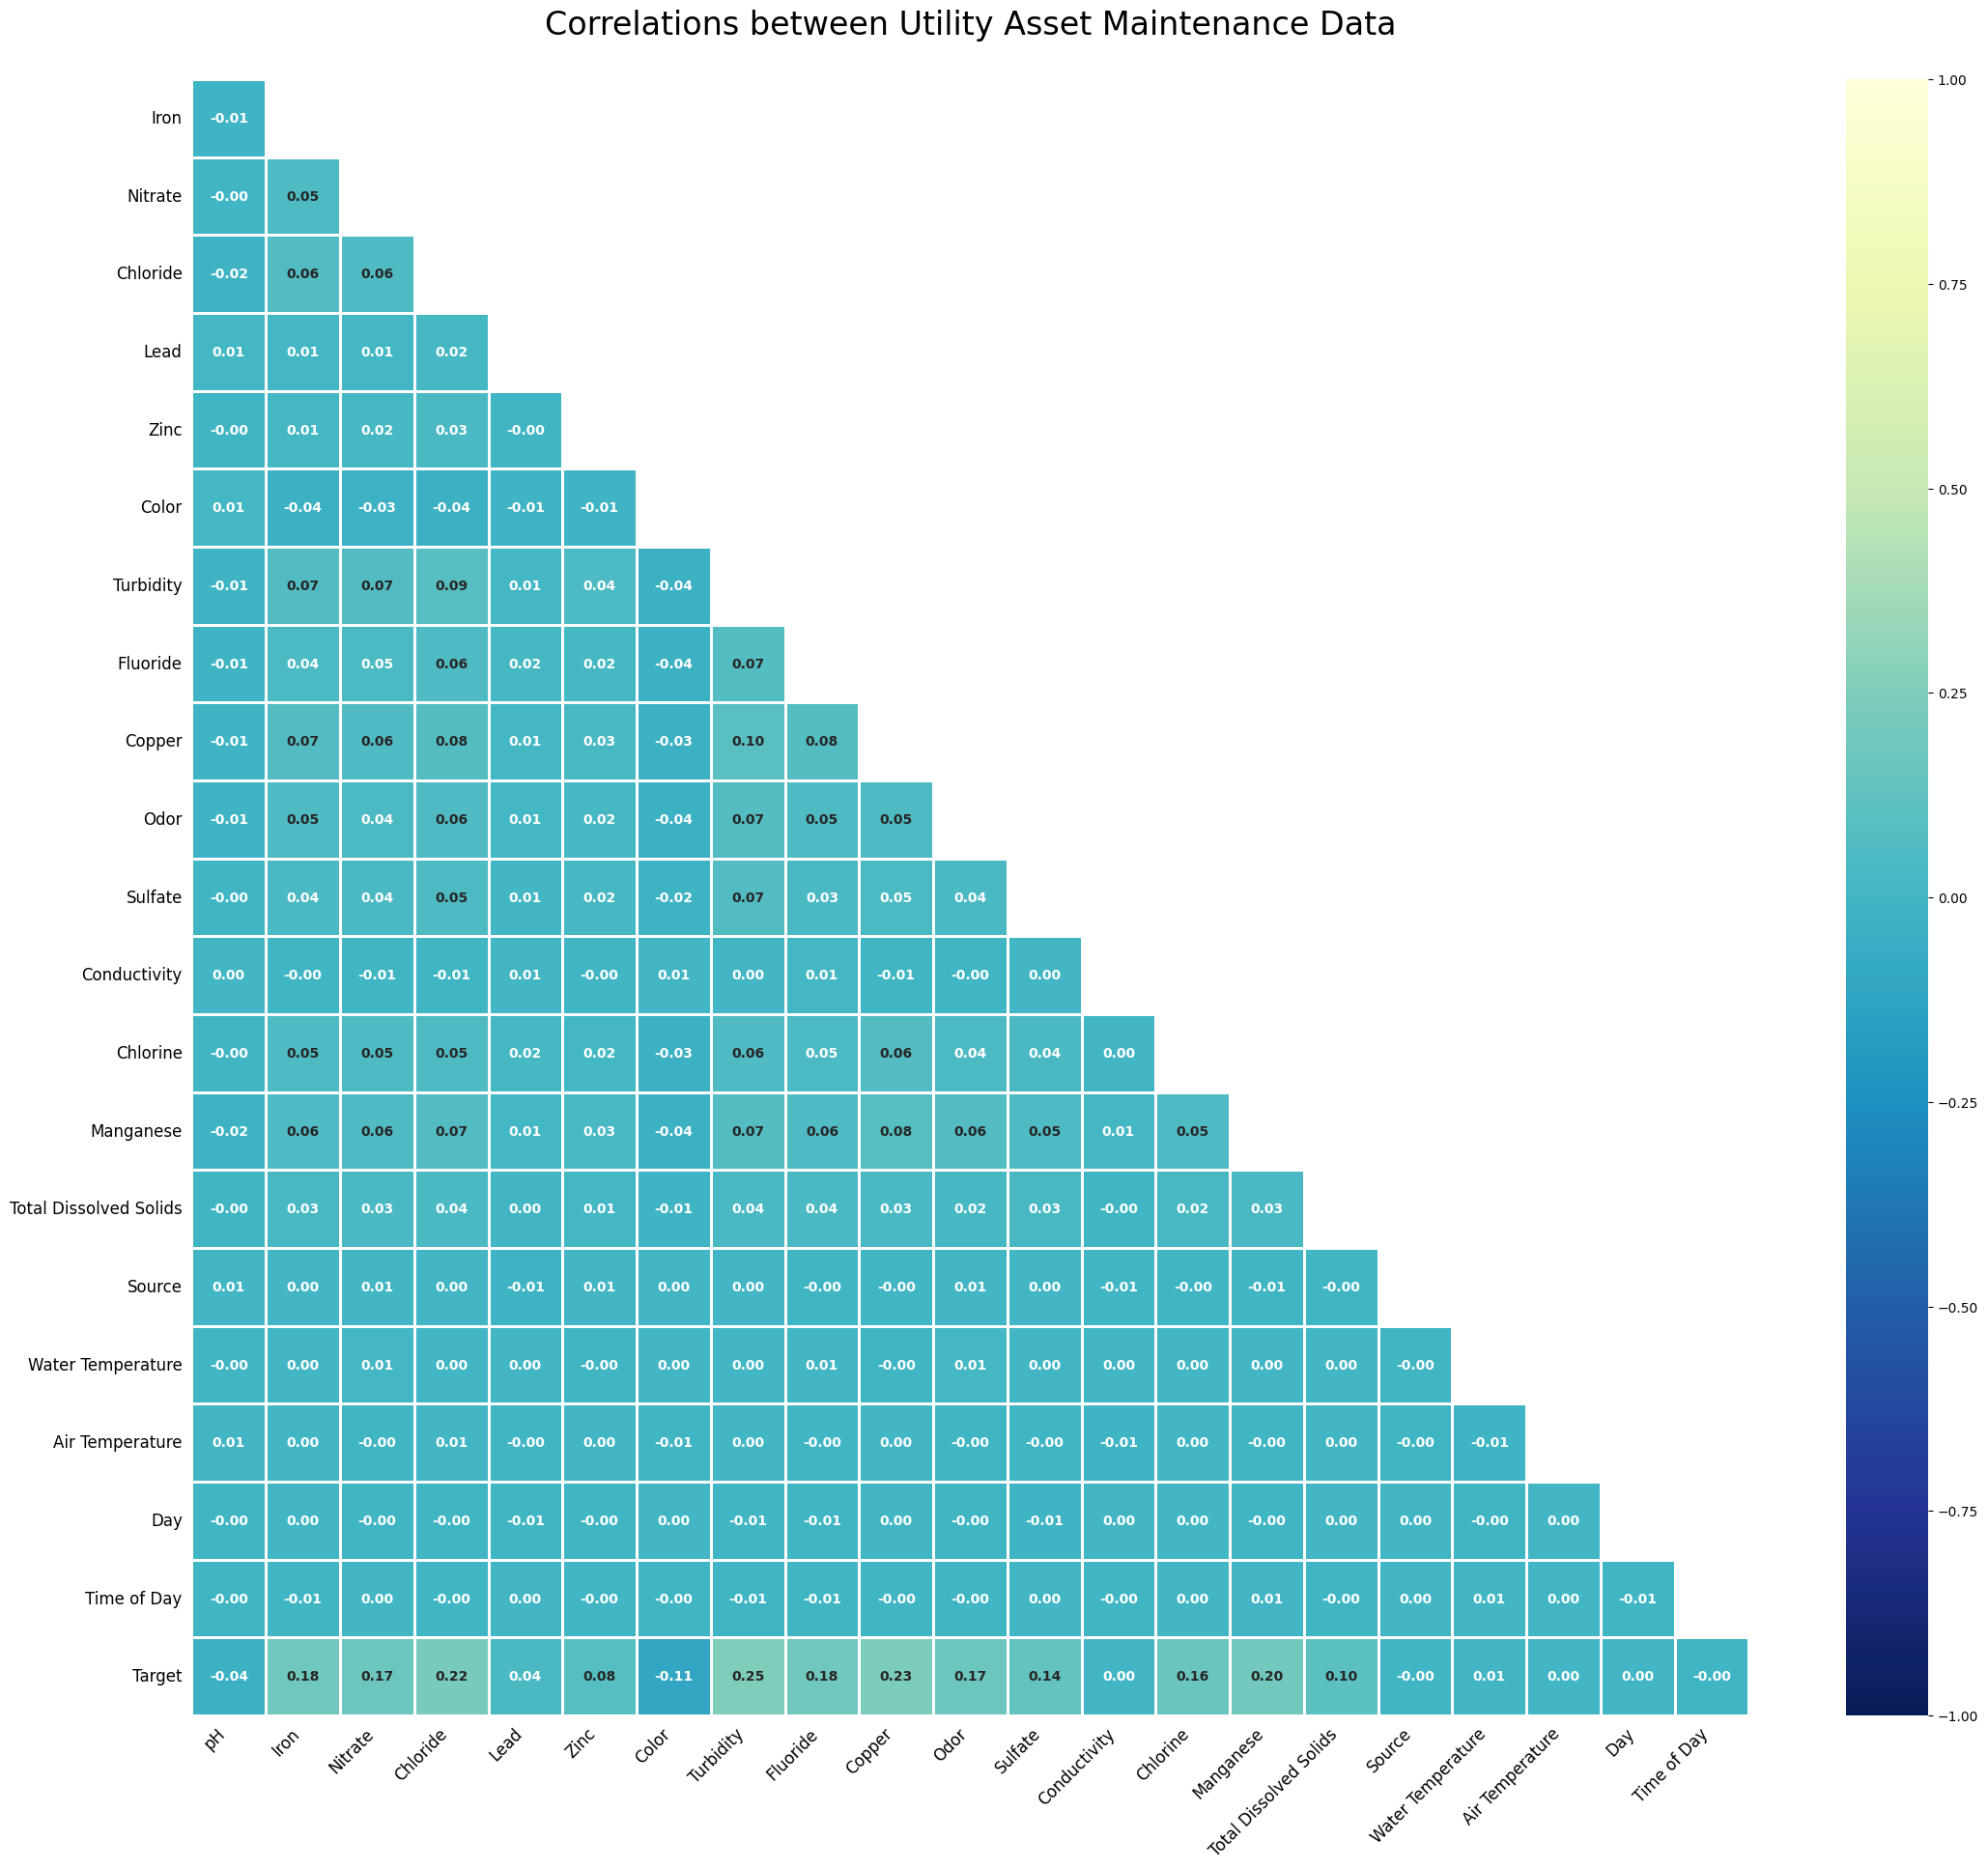

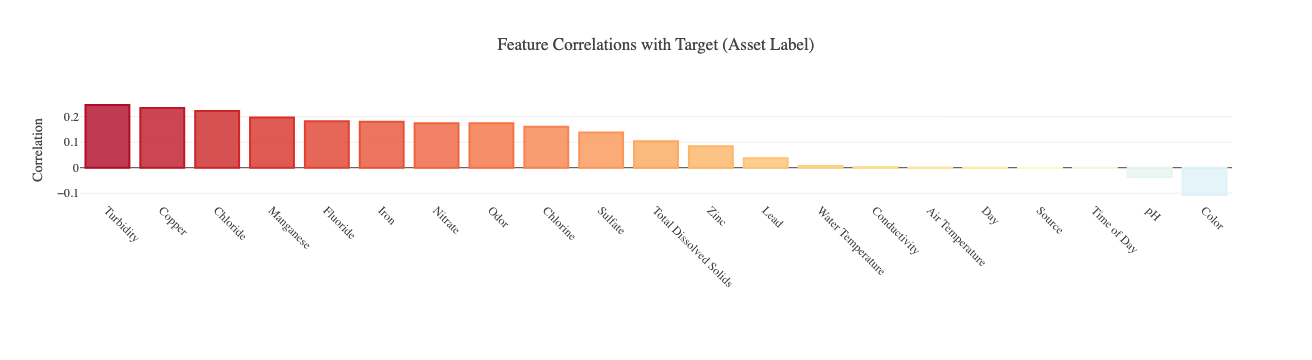

In [22]:
def plot_corr(corr):
    """
    Function to plot bottom left triangle of correlation matrix
    """
    mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
    corr=corr.iloc[1:,:-1].copy()
    fig, ax = plt.subplots(figsize=(26,22))   
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
                cmap='YlGnBu_r',lw=2, annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=True)
    ax.tick_params(left=False,bottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
    plt.title('Correlations\n', fontsize=24)
    plt.show()
    
def plot_target_corr(corr, target_col): 
    """
    Function to plot a bar chart of correlations between target and features, sorted in descending order
    """
    corr=corr[target_col].sort_values(ascending=False)[1:]
    pal=sns.color_palette("RdYlBu",37).as_hex()
    pal=[j for i,j in enumerate(pal) if i not in (17,18)]
    rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.8)) for i in pal] 
    
    fig=go.Figure()
    fig.add_trace(go.Bar(x=corr.index, y=corr, marker_color=rgb,
                         marker_line=dict(color=pal,width=2),
                         hovertemplate='%{x} correlation with Target = %{y}',
                         showlegend=False, name=''))
    fig.update_layout(template=temp, title='Feature Correlations with Target', 
                      yaxis_title='Correlation', margin=dict(b=160), xaxis_tickangle=45)
    fig.show()
    
corr=data.corr()
plot_corr(corr=corr)
plot_target_corr(corr=corr, target_col='Target')